# CNN Implementation : step 1, selecting the best model architecture

Necessary imports :

In [ ]:
from google.colab import drive
import zipfile
import os

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torchvision.models import resnet18, resnet50,  googlenet, inception_v3, mobilenet_v2, mobilenet_v3_small, mobilenet_v3_large, efficientnet_v2_m


## Data importation

Allow this notebook access to google drive:

In [ ]:
# Use drive.mount with force_remount=True
drive.mount('/content/drive')

Mounted at /content/drive


Extract the data from the zip file in the drive, to the Colab working directory (~40s runtime) :

In [ ]:
# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/ML Project 2 :)/data (2).zip'

# Extract to a working directory
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Normalize the data, and create the training and validation sets

In [ ]:
# Define the final transformation pipeline with normalization (optional)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats to use pretrained weights
])

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

# Check the shape of an image after transformation
first_image, first_label = train_dataset[0]
print(f"Shape of an image after transformation: {first_image.shape}")

Shape of an image after transformation: torch.Size([3, 224, 224])


## Exploring multiple architectures

We want to find what architecture is best suited for our classification task. We are going to try different models, with pretrained weights and 5 epochs. We use a basic Adam optimizer with learning rate 0.001 for all models, as it is a good strategy for many models. A batch size of 32 is a good compromise between speed and convergence.

We choose to use pretrained weights because after a quick test conducted on ResNet50 with 2 epochs, we estimate that it will provide better results (see CNN_my_norm.ipynb and CNN_pretraining.ipynb). Consequently, the right standardisation (based on ImageNet) and resizing to 224x224 has been done.

We choose 5 epochs because it should be sufficient to start observing what model will perform better generally, and we want to make good use of our computational time.

The model selection started from ResNet and GoogLeNet, quite classical models for computer vision, and MobileNet and EfficientNet as more varied models. Then according to the observed performance, we chose other versions of GoogLeNet (Inception) and MobileNet.

### Useful functions

In [ ]:
# Define number of epochs
num_epochs = 5

# Define loss
criterion = nn.CrossEntropyLoss()

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Default training function :

In [ ]:
def default_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Default Training - Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

A function to evaluate performance on the validation set, basis for our comparisons :

In [ ]:
def evaluate_model(model, val_loader, criterion, device):
    """
    Evaluates the model on a validation dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to run the evaluation on (CPU or GPU).

    Returns:
        dict: A dictionary containing validation loss, accuracy, and F1 score.
    """
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all labels and predictions for F1 score
            all_labels.extend(labels.cpu().numpy())       # Convert to numpy and store
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy and average loss
    accuracy = correct / total
    avg_val_loss = val_loss / len(val_loader)

    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance

    # Return results as a dictionary
    return {
        "validation_loss": avg_val_loss,
        "accuracy": accuracy * 100,  # Percentage
        "f1_score": f1
    }

### ResNet18

In [ ]:
# Load ResNet model with the updated 'weights' parameter
model = resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust the final layer for 2 classes

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Suppress model summary or logs by not printing it
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
default_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs)

Default Training - Epoch 1, Loss: 0.2335220359972856
Default Training - Epoch 2, Loss: 0.18138559385803163
Default Training - Epoch 3, Loss: 0.15749037644669514
Default Training - Epoch 4, Loss: 0.12898822454336173
Default Training - Epoch 5, Loss: 0.10008126241083636


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/resnet18_3rdRun.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/resnet18_3rdRun.pth', weights_only=True))

results = evaluate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {results['validation_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.2f}%")
print(f"F1 Score: {results['f1_score']:.4f}")

Validation Loss: 0.2525
Accuracy: 91.45%
F1 Score: 0.9117


### ResNet50

In [ ]:
# Load ResNet model with the updated 'weights' parameter
model = resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust the final layer for 2 classes

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Suppress model summary or logs by not printing it
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training :

In [ ]:
default_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs)

Default Training - Epoch 1, Loss: 0.233046756510043
Default Training - Epoch 2, Loss: 0.19334352272676816
Default Training - Epoch 3, Loss: 0.1738665737166051
Default Training - Epoch 4, Loss: 0.15802769290794635
Default Training - Epoch 5, Loss: 0.1443929637179655


Saving weights :

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/resnet50.pth')

Evaluating performance :

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/resnet50.pth', weights_only=True))

results = evaluate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {results['validation_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.2f}%")
print(f"F1 Score: {results['f1_score']:.4f}")

Validation Loss: 0.2696
Accuracy: 91.06%
F1 Score: 0.8973


### GoogLeNet

In [ ]:
# Load Inception-ResNet V2 model with the updated 'weights' parameter
model = googlenet(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 174MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
default_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs)

Default Training - Epoch 1, Loss: 0.20341019775471925
Default Training - Epoch 2, Loss: 0.1636338727617198
Default Training - Epoch 3, Loss: 0.13539876616571336
Default Training - Epoch 4, Loss: 0.1117715378686804
Default Training - Epoch 5, Loss: 0.09653054518732425


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/Googlenet.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/Googlenet.pth', weights_only=True))

results = evaluate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {results['validation_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.2f}%")
print(f"F1 Score: {results['f1_score']:.4f}")

Validation Loss: 0.2933
Accuracy: 92.66%
F1 Score: 0.9165


### Inception V3

In [ ]:
# Load Inception-ResNet V2 model with the updated 'weights' parameter
model = inception_v3(weights="IMAGENET1K_V1")  # Use IMAGENET1K_V1 weights
model.AuxLogits = nn.Sequential()  # Remove auxiliary classifier (optional, depending on your task)

# Adjust the final layer for 2 classes (binary classification)
model.fc = nn.Linear(model.fc.in_features, 2)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 208MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
import torchvision

# We neglect the auxiliary classifiers : we shouldn't need them given our task (binary classifier)
# and our data (medium size)
def Inception_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # If the model returns InceptionOutputs, extract only the main output (logits)
            if isinstance(outputs, torchvision.models.inception.InceptionOutputs):
                outputs = outputs.logits  # Use only the main output

            # Compute the loss using the main output
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Inception_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs)

Epoch 1, Loss: 0.2462647935482856
Epoch 2, Loss: 0.20834234960185474
Epoch 3, Loss: 0.19212795567685081
Epoch 4, Loss: 0.17072684607353272
Epoch 5, Loss: 0.15543333327984918



Running time : 50 min

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/InceptionV3.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/InceptionV3.pth', weights_only=True))

results = evaluate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {results['validation_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.2f}%")
print(f"F1 Score: {results['f1_score']:.4f}")

Validation Loss: 0.2261
Accuracy: 91.91%
F1 Score: 0.9194


### MobileNet V2

In [ ]:
# Load Inception-ResNet V2 model with the updated 'weights' parameter
model = mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 189MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
default_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs)

Default Training - Epoch 1, Loss: 0.20142519628679306
Default Training - Epoch 2, Loss: 0.15511047131696934
Default Training - Epoch 3, Loss: 0.13584342718697337
Default Training - Epoch 4, Loss: 0.11738043271607775
Default Training - Epoch 5, Loss: 0.0966200593902613


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV2.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV2.pth', weights_only=True))

results = evaluate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {results['validation_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.2f}%")
print(f"F1 Score: {results['f1_score']:.4f}")

Validation Loss: 0.2449
Accuracy: 91.77%
F1 Score: 0.9167


### MobileNet V3-S

In [ ]:
# Load Inception-ResNet V2 model with the updated 'weights' parameter
model = mobilenet_v3_small(weights="IMAGENET1K_V1")
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
default_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs)

Default Training - Epoch 1, Loss: 0.16145696006024796
Default Training - Epoch 2, Loss: 0.11485405493187821
Default Training - Epoch 3, Loss: 0.0869539680958648
Default Training - Epoch 4, Loss: 0.06739243043468342
Default Training - Epoch 5, Loss: 0.05359866596037653


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3S.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3S_3.pth', weights_only=True))

results = evaluate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {results['validation_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.2f}%")
print(f"F1 Score: {results['f1_score']:.4f}")

Validation Loss: 0.5542
Accuracy: 90.46%
F1 Score: 0.8800


We observe some overfitting (low training loss, significantly higher validation loss)

### MobileNet V3-L

In [ ]:
# Load Inception-ResNet V2 model with the updated 'weights' parameter
model = mobilenet_v3_large(weights="IMAGENET1K_V1")
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 133MB/s] 


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
default_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs)

Default Training - Epoch 1, Loss: 0.16849345395081294
Default Training - Epoch 2, Loss: 0.11485232061657406
Default Training - Epoch 3, Loss: 0.08756794422850933
Default Training - Epoch 4, Loss: 0.0654483656013041
Default Training - Epoch 5, Loss: 0.046607730606098685


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3L.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3L.pth', weights_only=True))

results = evaluate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {results['validation_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.2f}%")
print(f"F1 Score: {results['f1_score']:.4f}")

Validation Loss: 0.4976
Accuracy: 91.10%
F1 Score: 0.8881


It is worth noting that this performs worse than MobileNet V2. We observe a very low training loss but a validation loss that is 10 times higher, therefore some overfitting might be at play. This could be due to the excessive complexity of the model for our task and data, compared to MobileNet V2.

### EfficientNetV2-M

We choose size M for a good balance between accuracy and efficiency.

In [ ]:
# Load EfficientNet V2 model with the updated 'weights' parameter
model = efficientnet_v2_m(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # Change output to 2 (binary classification)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 209MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
default_training(train_loader, val_loader, model, criterion, optimizer, device, num_epochs)

Default Training - Epoch 1, Loss: 0.1849407634912424
Default Training - Epoch 2, Loss: 0.13118009195422214
Default Training - Epoch 3, Loss: 0.10301178355054136
Default Training - Epoch 4, Loss: 0.07748161371694319
Default Training - Epoch 5, Loss: 0.056195093190242414
Elapsed time: 5679.92 seconds


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/EfficientNetV2M.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/EfficientNetV2M.pth', weights_only=True))

results = evaluate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {results['validation_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.2f}%")
print(f"F1 Score: {results['f1_score']:.4f}")

Validation Loss: 0.3265
Accuracy: 90.48%
F1 Score: 0.9118


### Getting back all the metrics

In [ ]:
def get_metrics(model_path, model_name, train_loader, val_loader, criterion):
    """
    Loads a model based on the model_name, sets it up for binary classification,
    loads saved model weights, and computes training and validation metrics.

    Args:
        model_path (str): Path to the saved model weights.
        model_name (str): Name of the model architecture to load.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.

    Returns:
        None: The function prints out the training and validation results.
    """

    # Check if the provided model_name exists in torchvision.models
    if hasattr(models, model_name):

        # Use getattr to get the model function dynamically from torchvision.models
        model_fn = getattr(models, model_name)

        model = model_fn(weights="IMAGENET1K_V1")

        # Load the model with pre-trained weights
        if model_name == "efficientnet_v2_m":
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # Adjust the classifier layer
        elif model_name == "inception_v3":
            model.AuxLogits = nn.Sequential()  # Remove auxiliary classifier
            model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust the final fully connected layer
        elif model_name in ["mobilenet_v2", "mobilenet_v3_small", "mobilenet_v3_large"]:
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)  # Adjust the classifier layer
        else:
            model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust the final fully connected layer for binary classification

        # Load the model weights from the provided model_path
        model.load_state_dict(torch.load(model_path, weights_only=True))

        # Set the model to evaluation mode
        model.eval()

        # Move the model to the available device (CPU or GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Evaluate the model on training and validation data
        train_results = evaluate_model(model, train_loader, criterion, device)
        train_loss = train_results['validation_loss']
        train_f1 = train_results['f1_score']

        # Evaluate the model on validation data and print the results
        val_results = evaluate_model(model, val_loader, criterion, device)
        val_loss = val_results['validation_loss']
        val_f1 = val_results['f1_score']

        print(f"\nMetrics for {model_name}:")
        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    else:
        # Raise an error if the provided model_name is not recognized
        raise ValueError(f"Model name '{model_name}' is not recognized. Please provide a valid model name.")

In [ ]:
# List of model paths and corresponding model names
model_paths = [
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/EfficientNetV2M.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/Googlenet.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/Googlenet_2ndRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/Googlenet_3rdRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/InceptionV3.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/InceptionV3_2ndRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV2.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV2_2ndRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV2_3rdRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3L.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3L_2ndRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3S.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3S_2ndRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/MobileNetV3S_3rdRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/resnet18.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/resnet18_2ndRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/resnet18_3rdRun.pth',
    '/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_1_Model_archi/resnet50.pth'
]

model_names = [
    'efficientnet_v2_m',
    'googlenet',
    'googlenet',
    'googlenet',
    'inception_v3',
    'inception_v3',
    'mobilenet_v2',
    'mobilenet_v2',
    'mobilenet_v2',
    'mobilenet_v3_large',
    'mobilenet_v3_large',
    'mobilenet_v3_small',
    'mobilenet_v3_small',
    'mobilenet_v3_small',
    'resnet18',
    'resnet18',
    'resnet18',
    'resnet50'
]

# Assuming you have the train_loader, val_loader, and criterion set up:
for model_path, model_name in zip(model_paths, model_names):
    get_metrics(model_path, model_name, train_loader, val_loader, criterion)


Metrics for efficientnet_v2_m:
Train Loss: 0.0288, Train F1: 0.9892, Val Loss: 0.3265, Val F1: 0.9118

Metrics for googlenet:
Train Loss: 0.1238, Train F1: 0.9603, Val Loss: 0.2933, Val F1: 0.9165

Metrics for googlenet:
Train Loss: 0.1056, Train F1: 0.9658, Val Loss: 0.3340, Val F1: 0.8931

Metrics for googlenet:
Train Loss: 0.1549, Train F1: 0.9432, Val Loss: 0.2226, Val F1: 0.9238

Metrics for inception_v3:
Train Loss: 0.1973, Train F1: 0.9147, Val Loss: 0.2666, Val F1: 0.8812

Metrics for inception_v3:
Train Loss: 0.1479, Train F1: 0.9484, Val Loss: 0.2261, Val F1: 0.9194

Metrics for mobilenet_v2:
Train Loss: 0.1461, Train F1: 0.9496, Val Loss: 0.2512, Val F1: 0.9207

Metrics for mobilenet_v2:
Train Loss: 0.0936, Train F1: 0.9668, Val Loss: 0.2699, Val F1: 0.9096

Metrics for mobilenet_v2:
Train Loss: 0.0753, Train F1: 0.9735, Val Loss: 0.2449, Val F1: 0.9167


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 126MB/s] 



Metrics for mobilenet_v3_large:
Train Loss: 0.2603, Train F1: 0.9386, Val Loss: 0.8269, Val F1: 0.8703

Metrics for mobilenet_v3_large:
Train Loss: 0.2603, Train F1: 0.9386, Val Loss: 0.8269, Val F1: 0.8703

Metrics for mobilenet_v3_small:
Train Loss: 0.0975, Train F1: 0.9636, Val Loss: 0.4319, Val F1: 0.8916

Metrics for mobilenet_v3_small:
Train Loss: 0.0590, Train F1: 0.9758, Val Loss: 0.2751, Val F1: 0.9277

Metrics for mobilenet_v3_small:
Train Loss: 0.1822, Train F1: 0.9476, Val Loss: 0.5542, Val F1: 0.8800

Metrics for resnet18:
Train Loss: 0.2424, Train F1: 0.9296, Val Loss: 0.2630, Val F1: 0.9139

Metrics for resnet18:
Train Loss: 0.1162, Train F1: 0.9626, Val Loss: 0.2653, Val F1: 0.9079

Metrics for resnet18:
Train Loss: 0.0769, Train F1: 0.9737, Val Loss: 0.2525, Val F1: 0.9117


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]



Metrics for resnet50:
Train Loss: 0.1599, Train F1: 0.9395, Val Loss: 0.2696, Val F1: 0.8973


### Summary table

In [ ]:
import pandas as pd

# Create a dictionary to hold the data
data = {
    "loss (train)": [0.0288, 0.1281, 0.1726, 0.1050, 0.2295, 0.1129, 0.1452, 0.1559],
    "F1-score % (train)": [98.92, 95.64, 93.16, 96.33, 93.75, 96.23, 95.53, 93.95],
    "loss (val)": [0.3265, 0.2833, 0.2464, 0.2553, 0.6623, 0.4204, 0.2603, 0.2696],
    "F1-score % (val)": [91.18, 91.11, 90.03, 91.57, 87.92, 89.98, 91.12, 89.73],
    "Running time [min]": [95, 23, 50, 23, 20, 12, 21, 50],
}

# Define row names
row_names = [
    "EfficientNet V2-M", "GoogLeNet", "Inception V3",
    "MobileNet V2", "MobileNet V3-L", "MobileNet V3-S", "ResNet18",
    "ResNet50"
]

# Convert the dictionary into a DataFrame and set row names
df = pd.DataFrame(data, index=row_names)

# Display the DataFrame
df_sorted = df.sort_values(by="loss (val)", ascending=True)

# Display the sorted DataFrame
df_sorted

,loss (train),F1-score % (train),loss (val),F1-score % (val),Running time [min]
Inception V3,0.1726,93.16,0.2464,90.03,50
MobileNet V2,0.1050,96.33,0.2553,91.57,23
ResNet18,0.1452,95.53,0.2603,91.12,21
ResNet50,0.1559,93.95,0.2696,89.73,50
GoogLeNet,0.1281,95.64,0.2833,91.11,23
EfficientNet V2-M,0.0288,98.92,0.3265,91.18,95
MobileNet V3-S,0.1129,96.23,0.4204,89.98,12
MobileNet V3-L,0.2295,93.75,0.6623,87.92,20


Let's focus on the validation loss : we notice that the first 5 models of the table have somehow similar losses (between 0.24 and 0.28), and that the last 3 rows have larger losses, that are also way larger than their training one. This could be a sign of the last 3 models being too complex and overfitting. We will not consider them any further.

Then, we notice that for the first 5 models of the table, not only are the losses similar but the F1-scores are also quite close to each other (less than 2% absolute difference), therefore considering lighter models that can be trained faster and help us in our following steps could be a smart choice. Lighter models for similar performance also mean that the right amount of computational cost and memory is needed (we don't want to use more weights than necessary).

From this, we can keep 3 CNN architectures of interest : **MobileNet V2**, **ResNet18** and **GoogLeNet**, that use different strategies and that would therefore be interesting to explore further.

## More advanced model selection

In this section, we want to perform a higher quality training to better compare the models.

For the choice of optimizer that suits well the three models, we first looked at those that were used in the original papers: they were either Adam, or SGD with momentum. We then noticed that the PyTorch transfer learning tutorial used a learning rate lr=0.0001, so applied that to our models. However, the models started overfitting very strongly and fast, with lower validation losses. Then, we observed that using Adam with lr=0.001 showed better results, so the only added feature are 5 additional epochs, and some early stopping to prevent overfitting. The patience is set to 3, which is a nice amount considering the maximum number of epoch is 10. The training now also stores the best model (acc. to val. loss) accross all epochs.

For now weight decay is applied, in order to conserve the pretrained weights.

The ROC curves are plotted and the AUC are computed as an additional metrics to support our comparison. ROC curves are particularly powerful when comparing binary classifiers.

### Training the models

In [ ]:
import os
import torch

def train_and_plot(train_loader, val_loader, model_fn, criterion, optimizer_fn, device, num_epochs, n_trials, patience, save_dir):
    """
    Trains a model n times, saves the model after each trial, and plots the training and validation loss per epoch.
    Implements early stopping.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model_fn (function): A callable that returns a new model instance initialized with pre-trained weights.
        criterion (torch.nn.Module): Loss function.
        optimizer_fn (function): Function to create a new optimizer instance for each trial.
        device (torch.device): Device to use (CPU or GPU).
        num_epochs (int): Number of epochs per training.
        n_trials (int): Number of training repetitions.
        save_dir (str): Directory where the model for each trial will be saved.
        patience (int): Number of epochs to wait for validation loss improvement before stopping early.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    sample_model = model_fn()
    model_name = type(sample_model).__name__

    plt.figure(figsize=(10, 6))

    # To store all losses for averaging
    all_train_losses = []
    all_val_losses = []

    for trial in range(n_trials):
        # Reinitialize the model with ImageNet weights
        model = model_fn().to(device)

        # Create a new optimizer instance for this trial
        optimizer = optimizer_fn(model.parameters())

        train_losses = []
        val_losses = []

        best_val_loss = float('inf')  # Initialize to a large value
        patience_counter = 0  # Counter to track early stopping patience

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(val_loss)

            # Print loss for the current epoch
            print(f"Trial {trial + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset patience counter
                # Optionally save the best model for this trial
                trial_best_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}_best.pth")
                torch.save(model.state_dict(), trial_best_model_path)
                print(f"New best model for Trial {trial + 1} saved to {trial_best_model_path}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered for Trial {trial + 1} at Epoch {epoch + 1}")
                    break


        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot training and validation losses for this trial
        plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(range(1, len(val_losses) + 1), val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Calculate average losses per epoch
    avg_train_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_train_losses)]
    avg_val_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_val_losses)]

    # Plot average lines
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, color='blue', linewidth=2, label='Avg Training Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, color='orange', linewidth=2, label='Avg Validation Loss')

    # Finalize plot
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis shows integer epochs
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()


#### Model 1 : MobileNetV2

New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/MobileNetV2_trial_1_best.pth
Trial 1, Epoch 1, Train Loss: 0.1994, Val Loss: 0.2210
Trial 1, Epoch 2, Train Loss: 0.1538, Val Loss: 0.2529
Trial 1, Epoch 3, Train Loss: 0.1336, Val Loss: 0.2343
Early stopping triggered for Trial 1 at Epoch 4
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/MobileNetV2_trial_1.pth
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/MobileNetV2_trial_2_best.pth
Trial 2, Epoch 1, Train Loss: 0.1964, Val Loss: 0.2730
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/MobileNetV2_trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.1572, Val Loss: 0.2460
Trial 2, Epoch 3, Train Loss: 0.1342, Val Loss: 0.2463
Trial 

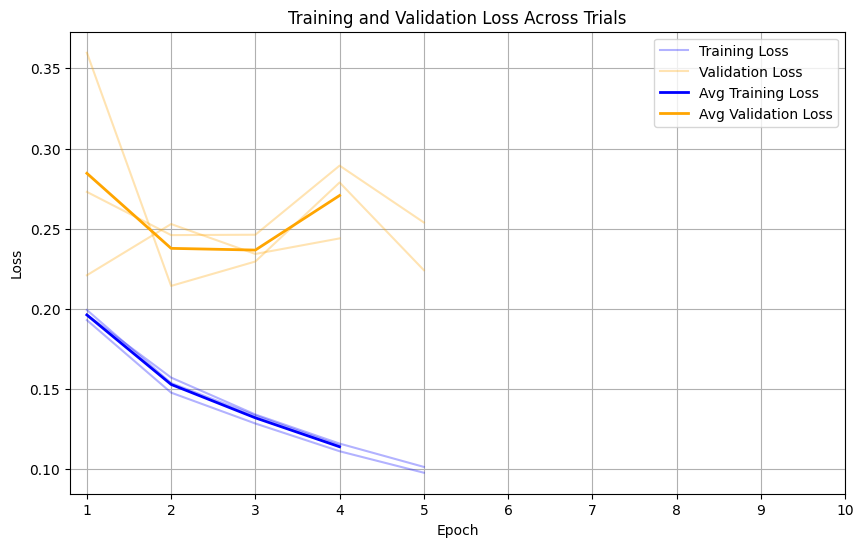

In [ ]:
def create_mobilenetv2():
    model = mobilenet_v2(weights="IMAGENET1K_V1")
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    return model

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

# Train and plot
train_and_plot(train_loader, val_loader, create_mobilenetv2, criterion, optimizer_fn,
               device, num_epochs=10, n_trials=3, patience=3, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial')

#### Model 2 : ResNet18

New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/ResNet_trial_1_best.pth
Trial 1, Epoch 1, Train Loss: 0.2486, Val Loss: 0.4199
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/ResNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.2034, Val Loss: 0.2864
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/ResNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1741, Val Loss: 0.2310
Trial 1, Epoch 4, Train Loss: 0.1574, Val Loss: 0.2376
Trial 1, Epoch 5, Train Loss: 0.1371, Val Loss: 0.2596
Early stopping triggered for Trial 1 at Epoch 6
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/ResNet_trial_1.pth
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Model_

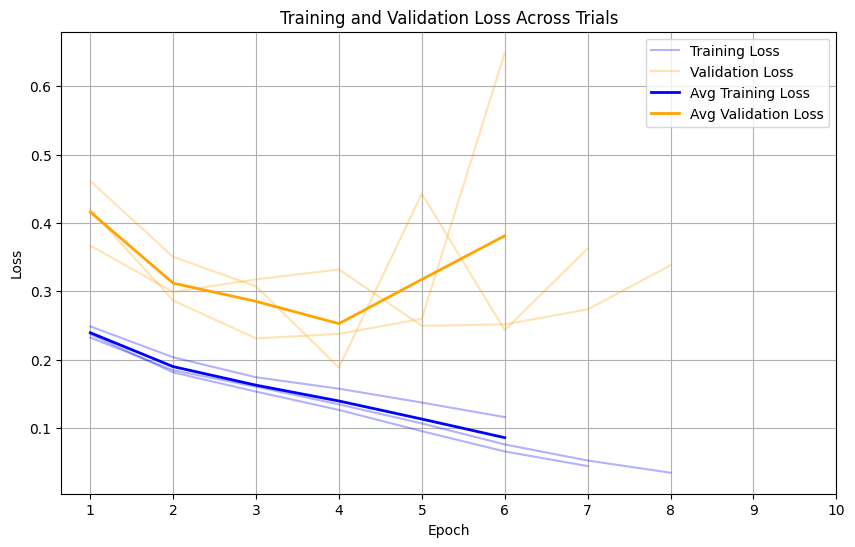

In [ ]:
def create_resnet18():
    model = resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

# Train and plot
train_and_plot(train_loader, val_loader, create_resnet18, criterion, optimizer_fn,
               device, num_epochs=10, n_trials=3,  patience=3, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial')

#### Model 3 : GoogLeNet

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 218MB/s]


New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 1, Train Loss: 0.2069, Val Loss: 0.2582
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1591, Val Loss: 0.2312
Trial 1, Epoch 3, Train Loss: 0.1368, Val Loss: 0.2324
Trial 1, Epoch 4, Train Loss: 0.1136, Val Loss: 0.2884
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 5, Train Loss: 0.0937, Val Loss: 0.2245
Trial 1, Epoch 6, Train Loss: 0.0778, Val Loss: 0.2461
Trial 1, Epoch 7, Train Loss: 0.0603, Val Loss: 0.2409
Early stopping triggered for Trial 1 at Epoch 8
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_sele

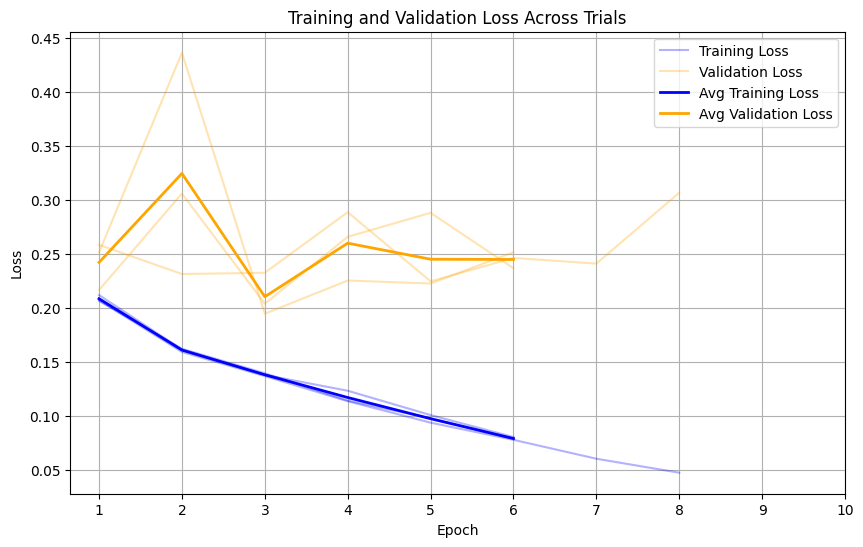

In [ ]:
def create_googlenet():
    model = googlenet(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=10, n_trials=3,  patience=3, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial')

### ROC curves and AUC

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_average_roc(models, val_loader, device, labels):
    """
    Plots the ROC curve for multiple models and their average.

    Args:
        models (list of torch.nn.Module): List of trained models.
        val_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to use (CPU or GPU).
        labels (list of str): Names of the models for legend labeling.
    """
    all_fpr = np.linspace(0, 1, 100)  # Common FPR axis for interpolation
    tpr_list = []  # Store TPR values for each model's interpolated curve
    auc_list = []  # Store AUC values for each model

    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        model.eval()
        true_labels = []
        pred_probs = []

        # Disable gradient computation during evaluation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                probabilities = outputs[:, 1]  # Use logits for positive class

                # Append true labels and predicted probabilities
                true_labels.extend(labels.cpu().numpy())
                pred_probs.extend(probabilities.cpu().numpy())

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        # Interpolate TPR to common FPR axis
        interpolated_tpr = np.interp(all_fpr, fpr, tpr)
        tpr_list.append(interpolated_tpr)

        # Plot individual model's ROC curve in light grey
        plt.plot(fpr, tpr, color='lightgrey', lw=1, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

    # Compute the average TPR
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve in blue
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f"Average (AUC = {mean_auc:.2f})")

    # Add baseline
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier (AUC = 0.5)")

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve Across Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [ ]:
# Define loss
criterion = nn.CrossEntropyLoss()

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Model 1 : MobileNetV2

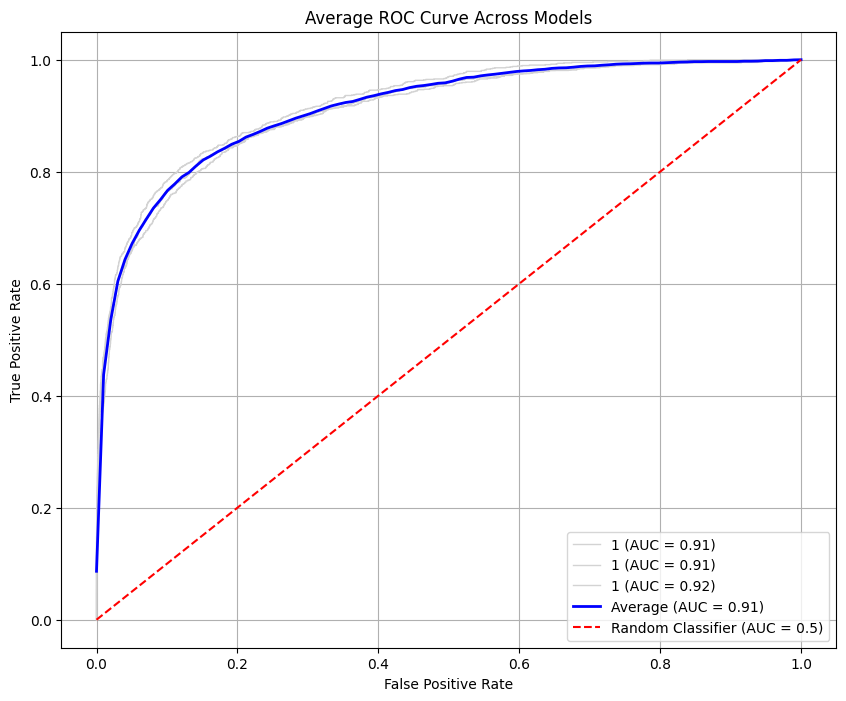

In [ ]:
mobilenet1 = mobilenet_v2(weights="IMAGENET1K_V1")
mobilenet1.classifier[-1] = nn.Linear(mobilenet1.classifier[-1].in_features, 2)
mobilenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/MobileNetV2_trial_1_best.pth', weights_only=True))

mobilenet2 = mobilenet_v2(weights="IMAGENET1K_V1")
mobilenet2.classifier[-1] = nn.Linear(mobilenet2.classifier[-1].in_features, 2)
mobilenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/MobileNetV2_trial_2_best.pth', weights_only=True))

mobilenet3 = mobilenet_v2(weights="IMAGENET1K_V1")
mobilenet3.classifier[-1] = nn.Linear(mobilenet3.classifier[-1].in_features, 2)
mobilenet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/MobileNetV2_trial_3_best.pth', weights_only=True))


my_models = [mobilenet1, mobilenet2, mobilenet3]
for model in my_models:
    model = model.to(device)
labels = ["mobilenet1", "mobilenet2", "mobilenet3"]

plot_average_roc(my_models, val_loader, device, labels)

#### Model 2 : ResNet18

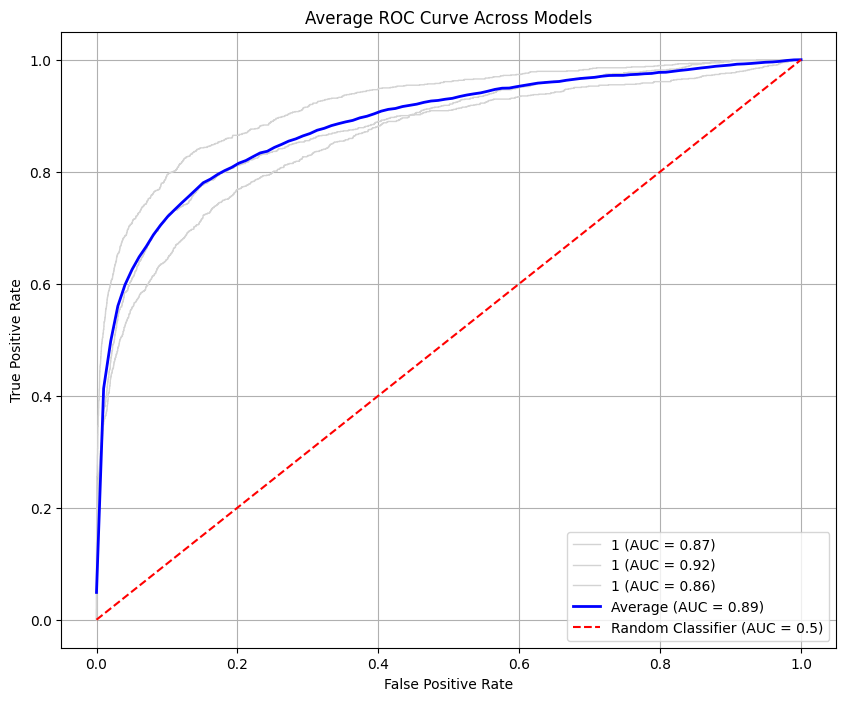

In [ ]:
resnet1 = models.resnet18(weights="IMAGENET1K_V1")
resnet1.fc = nn.Linear(resnet1.fc.in_features, 2)
resnet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/ResNet_trial_1_best.pth', weights_only=True))

resnet2 = models.resnet18(weights="IMAGENET1K_V1")
resnet2.fc = nn.Linear(resnet2.fc.in_features, 2)
resnet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/ResNet_trial_2_best.pth', weights_only=True))

resnet3 = models.resnet18(weights="IMAGENET1K_V1")
resnet3.fc = nn.Linear(resnet3.fc.in_features, 2)
resnet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/ResNet_trial_3_best.pth', weights_only=True))

my_models = [resnet1, resnet2, resnet3]
for model in my_models:
    model = model.to(device)
labels = ["resnet1", "resnet2", "resnet3"]

plot_average_roc(my_models, val_loader, device, labels)

#### Model 3 : GoogLeNet

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 133MB/s]


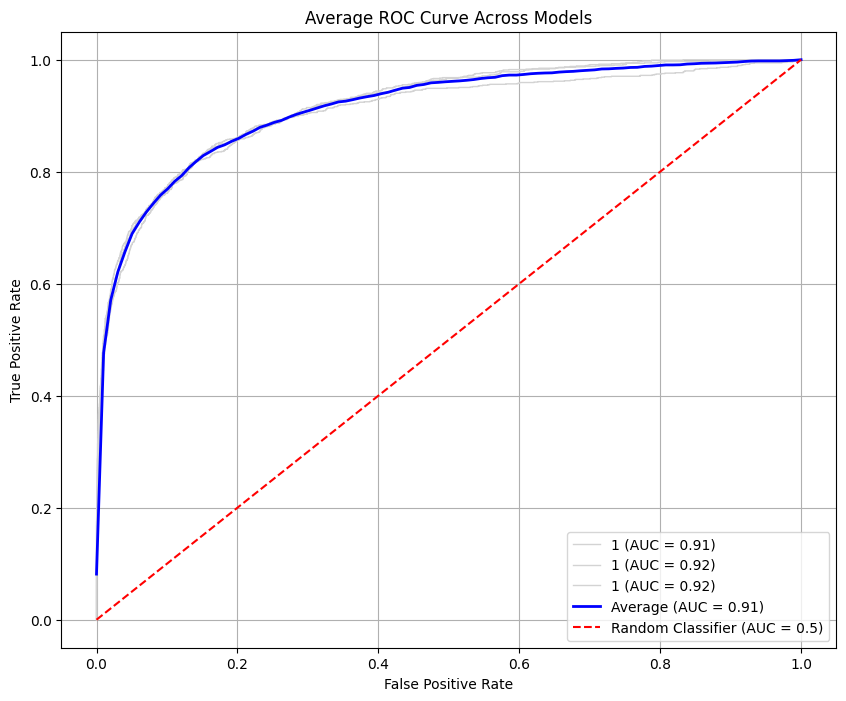

In [ ]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = models.googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/GoogLeNet_trial_2_best.pth', weights_only=True))

googlenet3 = models.googlenet(weights="IMAGENET1K_V1")
googlenet3.fc = nn.Linear(googlenet3.fc.in_features, 2)
googlenet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Advanced_model_selection/second_trial/GoogLeNet_trial_3_best.pth', weights_only=True))

my_models = [googlenet1, googlenet2, googlenet3]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2", "googlenet3"]

plot_average_roc(my_models, val_loader, device, labels)

## Model selection : conclusion

Considering the binary cross-entropy losses over the validation set, and taking the average over the three runs, GoogLeNet has the lowest loss (0.2076) followed by ResNet18 (0.2230) and MobileNetV2 (0.2271).

Looking at the AUCs, GoogLeNet also comes first (0.91) tied with MobileNetV2 (0.91) and ResNet18 (0.89).

We can also note that ResNet18 has the highest variance in results, as shown by the ROC curves. In addition, the training of MobileNetV2 is stopped the earliest and indicates higher overfitting.

Therefore, the best option seems to be GoogLeNet.